# Ensemble Additional Data USA + Nagoya Notebook

Version: **12**

### Update:
- Data `Cleaning`
- Fix epsilon of Metrics `IoU`
- Intencity Augmentation for FP prediction
- `Toyko` Area Data


In [10]:
%load_ext dotenv
%dotenv ./key.env -o -v

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Import 

In [11]:
import os
import warnings
import random
from pprint import pprint
import copy
from typing import List, Tuple
import glob
import json
import csv
# import dataclasses
from joblib import Parallel, delayed

from tqdm import tqdm
import numpy as np
import pandas as pd
from box import Box, from_file
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import minimize
from sklearn.metrics import jaccard_score
import cv2
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, KFold
import torch
print(torch.__version__)
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from timm import create_model
import segmentation_models_pytorch as smp
# from torchmetrics import FBetaScore
import ttach as tta
import torchvision

import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger, CSVLogger
from pytorch_lightning import LightningDataModule, LightningModule

import wandb
wandb.login(key=os.environ["WANDB_API_KEY"])

warnings.filterwarnings("ignore")

torch.autograd.set_detect_anomaly(True)
pd.options.display.max_colwidth = 250
pd.options.display.max_rows = 30

# インライン表示
%matplotlib inline

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/syu/.netrc


1.8.0+cu111
1.6.0


## Condig

In [12]:
from typing import List, Set, Dict, Any

base_channel = 16

class CFG(object):
    # basic
    debug: bool = False
    debug_sample: int = 64
    folds: int  = 4
    seed: int   = 417
    eps: float  = 1e-12
    
    SINGLE_FOLD = False
    
    # data
    PATH_CSV: str  =  f'../data/002_Full+California/012_seed417.csv'
    PATH_CSV_TOKYO = '../data/019_Tokyo/019_seed417.csv'
    PATH_CSV_NAGOYA = '../data/021_Nagoya/019_seed417.csv'
    PATH_CSV_ARIZONA = '../data/021_Arizona/019_seed417.csv'
    PATH_CSV_NEVATA = '../data/021_Nevata/019_seed417.csv'
    PATH_CSV_OREGON = '../data/021_Oregon/019_seed417.csv'
    
    # train
    epoch: int  = 10
    # early_stop_patience:int = int(epoch /10)
    trainer: Dict[str, Any]   = {
        'gpus': 1,
        'accumulate_grad_batches': 2,
        'progress_bar_refresh_rate': 1,
        'stochastic_weight_avg': False,
        'fast_dev_run': False,
        'num_sanity_val_steps': 0,
        'resume_from_checkpoint': None,
        'check_val_every_n_epoch': 2,
        'val_check_interval': 1.0,
        # 'precision' : 16,
        'gradient_clip_val': 15., 
        'gradient_clip_algorithm': "value"
    }
    optimizer: Dict[str, Any] = {
        'name': 'optim.AdamW',
        'params': {
            'lr': 1e-4,
            'weight_decay': 1e-4,
            },
    }
    scheduler: Dict[str, Any] = {
        'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
        'params':{
            'T_0': epoch,
            'eta_min': 1e-5,
            }
    }
    
    base_channel = base_channel # python bug?
    opt_beta = 0.25
    model: Dict[str, Any] = {
        'timmunet': {
                'encoder_params': {  
                    "encoder": "hrnet_w30",
                    "decoder_filters": [base_channel * (i+1) for i in range(4)],
                    "last_upsample": base_channel,
                },
        },
        'loss': f'BCEDiceLoss(beta={opt_beta})',
        'threshold': 0.3,
    }
    
    BATCH_SIZE = 16
    train_loader: Dict[str, Any] = {
        'batch_size': BATCH_SIZE,
        'shuffle': True,
        'num_workers': 8,
        'pin_memory': True,
        'drop_last': True,
    }
    val_loader :Dict[str, Any]= {
        'batch_size': BATCH_SIZE*2,
        'shuffle': False,
        'num_workers': 8,
        'pin_memory': True,
        'drop_last': False
    }
    
    MIXUP_RATIO = 0.5
    
    # preprocess
    percentiles = False # list: `[1, 99]` or False ## if False, use RAW values, 
    preprocess: Dict = {
        "input_size": 512,
    }
    
    # data
    use_california = False # 'full', 'only', False: is baseline state
    use_defect = True
    use_non_fold = True
    
    # missing data
    REMOVE_POST_MISSING = True
    REMOVE_PRE_MISSING = True
    
    # cleaning info
    PATH_CLEAN_JSON = '../data/016_cleaning.json'
    
    
    # experiment
    ENV = '3090'
    VERSION = 12
    outdir: str = f'output/V{VERSION}/'
    
    info = f'CAL{use_california}DEF{use_defect}NON{use_non_fold}_'
    # model info
    info += f'{model["timmunet"]["encoder_params"]["encoder"]}'
    info += f'BC{base_channel}TH{model["threshold"]}'
    if percentiles:
        info += f'PER{percentiles[0]}-{percentiles[1]}'
    if REMOVE_POST_MISSING:
        info += '_R-RPM'
    if REMOVE_PRE_MISSING:
        info += '_R-RPM'
    
    # train info
    info += f'_fl-tr-gr_WD{optimizer["params"]["weight_decay"]}E{epoch}GA{trainer["accumulate_grad_batches"]}'
    info += f'BETA{opt_beta}MIX{MIXUP_RATIO}B{train_loader["batch_size"]}'
    
    # logging
    project: str = "ChaBuD-ECML-PKDD2023"
    runname: str = f"{ENV}"
    group: str   = f'{ENV}_V{VERSION}_{info}'
    notebook: str = '023_additional_us.ipynb'
    
    # post info
    augmentation: str =  ''
    fold: int = -1
        

    if debug:
        epoch = 2
        group = 'DEBUG'


# box
cfg = Box({k:v for k, v in dict(vars(CFG)).items() if '__' not in k})
    
# 乱数のシードを設定
seed_everything(cfg.seed)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)
    
pprint(cfg)

Global seed set to 417


{'BATCH_SIZE': 16,
 'ENV': '3090',
 'MIXUP_RATIO': 0.5,
 'PATH_CLEAN_JSON': '../data/016_cleaning.json',
 'PATH_CSV': '../data/002_Full+California/012_seed417.csv',
 'PATH_CSV_ARIZONA': '../data/021_Arizona/019_seed417.csv',
 'PATH_CSV_NAGOYA': '../data/021_Nagoya/019_seed417.csv',
 'PATH_CSV_NEVATA': '../data/021_Nevata/019_seed417.csv',
 'PATH_CSV_OREGON': '../data/021_Oregon/019_seed417.csv',
 'PATH_CSV_TOKYO': '../data/019_Tokyo/019_seed417.csv',
 'REMOVE_POST_MISSING': True,
 'REMOVE_PRE_MISSING': True,
 'SINGLE_FOLD': False,
 'VERSION': 12,
 'augmentation': '',
 'base_channel': 16,
 'debug': False,
 'debug_sample': 64,
 'epoch': 10,
 'eps': 1e-12,
 'fold': -1,
 'folds': 4,
 'group': '3090_V12_CALFalseDEFTrueNONTrue_hrnet_w30BC16TH0.3_R-RPM_R-RPM_fl-tr-gr_WD0.0001E10GA2BETA0.25MIX0.5B16',
 'info': 'CALFalseDEFTrueNONTrue_hrnet_w30BC16TH0.3_R-RPM_R-RPM_fl-tr-gr_WD0.0001E10GA2BETA0.25MIX0.5B16',
 'model': {'loss': 'BCEDiceLoss(beta=0.25)',
           'threshold': 0.3,
           'ti

## Augmentation

In [13]:
class DynamicChannelPercentileNormalization(A.ImageOnlyTransform):
    """ Preprocessing for Dynamic Range """
    def __init__(self, percentiles: List[float] = [0.5, 99.5]) -> None:
        super().__init__(always_apply=True)
        assert percentiles[0] < percentiles[1], 'Check percentiles order and values'
        self.percentiles = percentiles

    def apply(self, img: Any, **params: Any) -> Any:
        
        for ch in range(24):
            im = img[:, :, ch]
            top, bottom = np.percentile(im, max(self.percentiles)), np.percentile(im, min(self.percentiles))
            im = np.clip(img[:, :, ch], a_min=bottom, a_max=top)
            img[:, :, ch] = (im - bottom) / (top - bottom)
        return img

    def get_transform_init_args_names(self) -> Tuple[str]:
        return ("percentiles",)
    
class MultiHSV(A.ImageOnlyTransform):
    """ Multi Channel HSV Augmentation"""
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(always_apply=True)
        self.transform = A.HueSaturationValue(*args, **kwargs)

    def apply(self, img: Any, **params: Any) -> Any:
        
        for ch in range(24):
            im = img[:, :, ch]
            img[:, :, ch] = self.transform(image=im)['image']
        return img

    def get_transform_init_args_names(self) -> Tuple[str]:
        return ("transform",)
    
PREPROCESS = []
if cfg.percentiles:
    PREPROCESS.append(DynamicChannelPercentileNormalization(percentiles=cfg.percentiles))

# augmentation
tf_dict = {
    
    'train': A.Compose(
        PREPROCESS +         
        [
            #### Mask Value `0` only for geocode masking ####
            
            # A.CoarseDropout(max_holes=4, max_height=4, max_width=4, 
            #                     min_holes=None, min_height=None, min_width=None, 
            #                     fill_value=0.15, mask_fill_value=0.0, always_apply=False, p=0.25),
            # A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1,
            #                     border_mode=4, value=None, mask_value=None, always_apply=False,
            #                     approximate=False, same_dxdy=False, p=0.25),
            # A.GridDistortion(num_steps=5, distort_limit=0.4, interpolation=1, 
            #                     border_mode=4, value=None, mask_value=None, always_apply=False, p=0.25),
            # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, interpolation=1, 
            #                     border_mode=4, value=0.01, mask_value=0.0, shift_limit_x=None, shift_limit_y=None, 
            #                     p=0.5),
            # MultiHSV(
            #     hue_shift_limit=1, sat_shift_limit=1, val_shift_limit=1, 
            #     always_apply=False, p=0.75),
            A.OneOf([
                A.GaussNoise(var_limit=(1e-3, 1e-2), mean=0., p=0.5),
                # A.Blur(blur_limit=3, p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=True, p=0.5),
            ], p=0.9),
            A.Transpose(p=0.25),
            A.Flip(p=0.5),
            # A.Rotate(limit=30, p=0.5),
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            ToTensorV2(),
            ]
        ),
    'val': A.Compose(
        PREPROCESS +  
        [
            A.Resize(cfg.preprocess.input_size, cfg.preprocess.input_size),
            ToTensorV2(),
        ]
    ),
}

cfg.augmentation = str(tf_dict).replace('\n', '').replace(' ', '')
pprint(cfg.augmentation)

"{'train':Compose([OneOf([GaussNoise(always_apply=False,p=0.5,var_limit=(0.001,0.01),per_channel=True,mean=0.0),RandomBrightnessContrast(always_apply=False,p=0.5,brightness_limit=(-0.1,0.1),contrast_limit=(-0.1,0.1),brightness_by_max=True),],p=0.9),Transpose(always_apply=False,p=0.25),Flip(always_apply=False,p=0.5),Resize(always_apply=False,p=1,height=512,width=512,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={}),'val':Compose([Resize(always_apply=False,p=1,height=512,width=512,interpolation=1),ToTensorV2(always_apply=True,p=1.0,transpose_mask=False),],p=1.0,bbox_params=None,keypoint_params=None,additional_targets={})}"


## Dataset

In [14]:
dfs = []

# Open Data
df = pd.read_csv(cfg.PATH_CSV)
df['area'] = 'unknown'
df['h_idx'] = -1
df['w_idx'] = -1 
dfs.append(df)

# Tokyo Data
df = pd.read_csv(cfg.PATH_CSV_TOKYO)
df['h_idx'] = df['name'].apply(lambda x: int(x.split('_')[1][1:]))
df['w_idx'] = df['name'].apply(lambda x: int(x.split('_')[2][1:]))
df['post_missing'] = False
df['pre_missing'] = False
dfs.append(df)

# Nagoya Data
df = pd.read_csv(cfg.PATH_CSV_NAGOYA)
df['h_idx'] = df['name'].apply(lambda x: int(x.split('_')[1][1:]))
df['w_idx'] = df['name'].apply(lambda x: int(x.split('_')[2][1:]))
df['post_missing'] = False
df['pre_missing'] = False
dfs.append(df)

# Arizona Data
df = pd.read_csv(cfg.PATH_CSV_ARIZONA)
df['h_idx'] = df['name'].apply(lambda x: int(x.split('_')[1][1:]))
df['w_idx'] = df['name'].apply(lambda x: int(x.split('_')[2][1:]))
df['post_missing'] = False
df['pre_missing'] = False
dfs.append(df)

# Nevata Data
df = pd.read_csv(cfg.PATH_CSV_NEVATA)
df['h_idx'] = df['name'].apply(lambda x: int(x.split('_')[1][1:]))
df['w_idx'] = df['name'].apply(lambda x: int(x.split('_')[2][1:]))
df['post_missing'] = False
df['pre_missing'] = False
dfs.append(df)

# Oregon Data
df = pd.read_csv(cfg.PATH_CSV_OREGON)
df['h_idx'] = df['name'].apply(lambda x: int(x.split('_')[1][1:]))
df['w_idx'] = df['name'].apply(lambda x: int(x.split('_')[2][1:]))
df['post_missing'] = False
df['pre_missing'] = False
dfs.append(df)

df = pd.concat(dfs)
print(df.shape)

if cfg.use_california == 'only':
    df = df[df['california'] == True]
elif cfg.use_california == 'full':
    pass
else:
    df = df[df['california'] == False]
    
if cfg.use_defect:
    pass
else:
    df = df[df['defects'] == False]
    
if cfg.use_non_fold:
    pass
else:
    df = df[df['fold'] != -1]
    
# cleaning process
with open(cfg.PATH_CLEAN_JSON, 'r') as f:
    clean_info = json.load(f)

REMOVE_LIST = [k for (k,v) in clean_info.items() if v["remove"]]
print(f'NUM REMOVE DATA: {len(REMOVE_LIST)}')

df['remove'] = df['name'].isin(REMOVE_LIST)
df = df[df['remove'] == False]


"""
Pre Search ID
"""

df['search_idx'] = range(df.shape[0])

def search_same_patch_area(row):
    if row.area in ['tokyo', 'nagoya', 'Arizona', 'Nevata', 'Oregon']:
        df_filtered = df[(df['h_idx'] == row.h_idx) & (df['w_idx'] == row.w_idx) & (df['area'] == row.area)]
        row_same_area_idx = df_filtered.feature.to_list()
        return row_same_area_idx
    else:
        return False

tqdm.pandas()
df['same_idx'] = df.progress_apply(search_same_patch_area, axis=1, result_type='expand')


# check
print('ALL Train data:', len(df))
df.sample(6)

(27102, 15)
NUM REMOVE DATA: 13


100%|██████████| 25658/25658 [00:37<00:00, 689.82it/s]

ALL Train data: 25658


,name,feature,mask,defects,fold,hight,width,california,pre_missing,post_missing,ratio,cv,area,h_idx,w_idx,remove,search_idx,same_idx
251,54-S-UE-2023-5-17_h11_w20,../data/019_Tokyo/img/54-S-UE-2023-5-17_h11_w20.npy,False,False,-1,512,512,False,False,False,NaN,-1,tokyo,11,20,False,772,"[../data/019_Tokyo/img/54-S-UE-2023-5-17_h11_w20.npy, ../data/019_Tokyo/img/54-S-UE-2023-5-2_h11_w20.npy, ../data/019_Tokyo/img/54-S-UE-2023-4-27_h11_w20.npy, ../data/019_Tokyo/img/54-S-UE-2023-4-17_h11_w20.npy, ../data/019_Tokyo/img/54-S-UE-2023..."
1501,11-T-PH-2022-9-25_h8_w10,../data/021_Arizona/img/11-T-PH-2022-9-25_h8_w10.npy,False,False,-1,512,512,False,False,False,NaN,-1,Arizona,8,10,False,12165,"[../data/021_Arizona/img/11-T-PH-2022-10-20_h8_w10.npy, ../data/021_Arizona/img/11-T-PH-2022-10-15_h8_w10.npy, ../data/021_Arizona/img/11-T-PH-2022-10-10_h8_w10.npy, ../data/021_Arizona/img/11-T-PH-2022-9-25_h8_w10.npy, ../data/021_Arizona/img/11..."
798,11-S-NC-2023-5-13_h17_w0,../data/021_Nevata/img/11-S-NC-2023-5-13_h17_w0.npy,False,False,-1,512,512,False,False,False,NaN,-1,Nevata,17,0,False,16313,"[../data/021_Nevata/img/11-S-NC-2023-5-18_h17_w0.npy, ../data/021_Nevata/img/11-S-NC-2023-5-13_h17_w0.npy, ../data/021_Nevata/img/11-S-NC-2023-4-28_h17_w0.npy, ../data/021_Nevata/img/11-S-NC-2023-4-18_h17_w0.npy, ../data/021_Nevata/img/11-S-NC-20..."
409,10-T-DQ-2023-5-25_h19_w10,../data/021_Oregon/img/10-T-DQ-2023-5-25_h19_w10.npy,False,False,-1,512,512,False,False,False,NaN,-1,Oregon,19,10,False,21657,"[../data/021_Oregon/img/10-T-DQ-2023-5-25_h19_w10.npy, ../data/021_Oregon/img/10-T-DQ-2023-2-9_h19_w10.npy, ../data/021_Oregon/img/10-T-DQ-2023-1-30_h19_w10.npy, ../data/021_Oregon/img/10-T-DQ-2022-12-16_h19_w10.npy, ../data/021_Oregon/img/10-T-D..."
359,11-S-NC-2023-5-18_h17_w2,../data/021_Nevata/img/11-S-NC-2023-5-18_h17_w2.npy,False,False,-1,512,512,False,False,False,NaN,-1,Nevata,17,2,False,15874,"[../data/021_Nevata/img/11-S-NC-2023-5-18_h17_w2.npy, ../data/021_Nevata/img/11-S-NC-2023-5-13_h17_w2.npy, ../data/021_Nevata/img/11-S-NC-2023-4-28_h17_w2.npy, ../data/021_Nevata/img/11-S-NC-2023-4-18_h17_w2.npy, ../data/021_Nevata/img/11-S-NC-20..."
1457,54-S-UE-2023-4-17_h6_w8,../data/019_Tokyo/img/54-S-UE-2023-4-17_h6_w8.npy,False,False,-1,512,512,False,False,False,NaN,-1,tokyo,6,8,False,1978,"[../data/019_Tokyo/img/54-S-UE-2023-5-17_h6_w8.npy, ../data/019_Tokyo/img/54-S-UE-2023-5-2_h6_w8.npy, ../data/019_Tokyo/img/54-S-UE-2023-4-27_h6_w8.npy, ../data/019_Tokyo/img/54-S-UE-2023-4-17_h6_w8.npy, ../data/019_Tokyo/img/54-S-UE-2023-4-12_h6..."


######## Phase val Num sample: 25658


  0%|          | 0/802 [00:00<?, ?it/s]

torch.Size([32, 24, 512, 512]) torch.Size([32, 512, 512])


  0%|          | 0/802 [00:11<?, ?it/s]


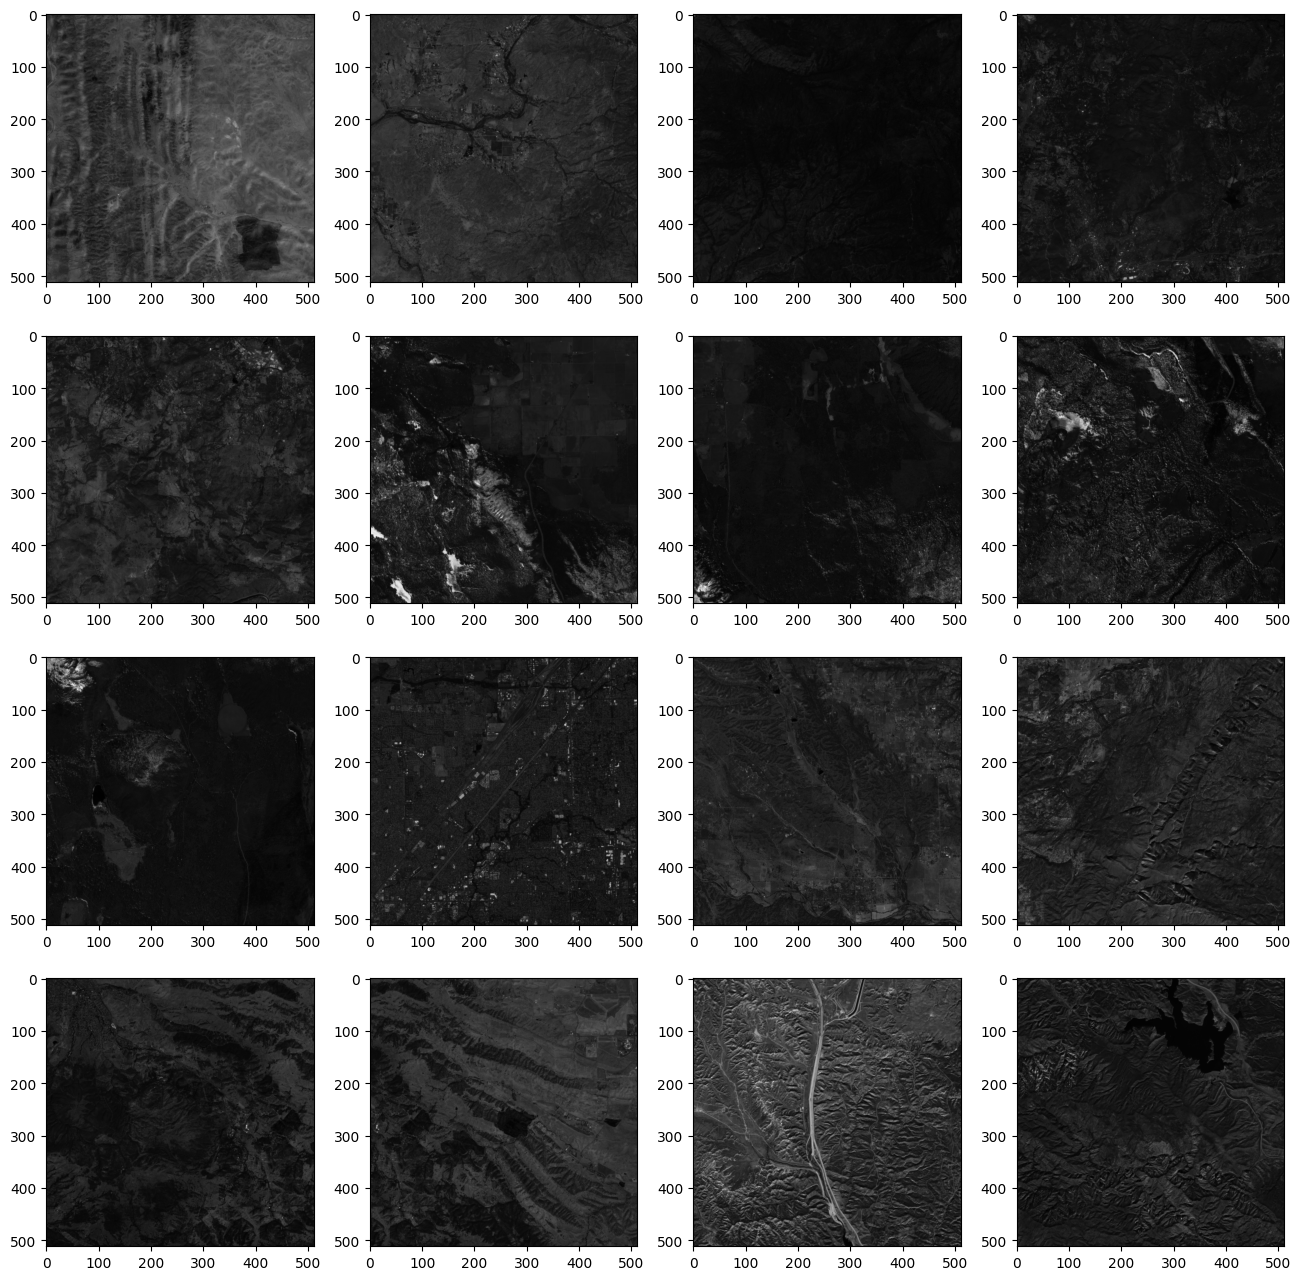

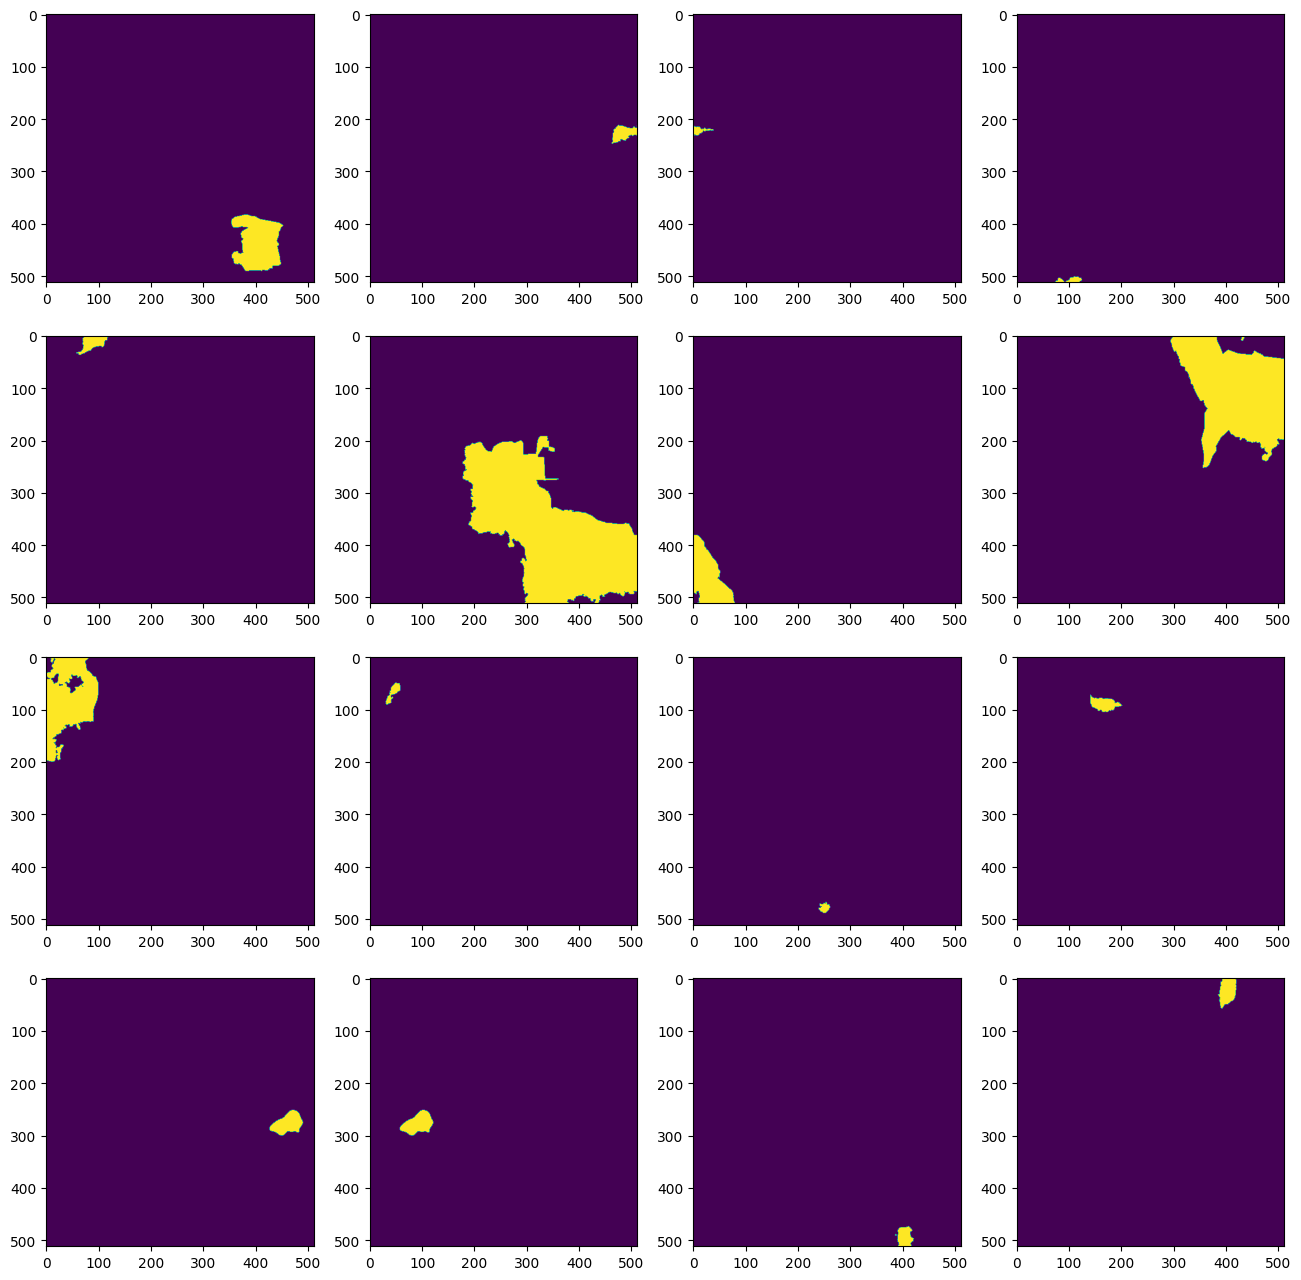

######## Phase train Num sample: 25658


  0%|          | 0/1603 [00:00<?, ?it/s]

torch.Size([16, 24, 512, 512]) torch.Size([16, 512, 512])


  0%|          | 0/1603 [00:12<?, ?it/s]


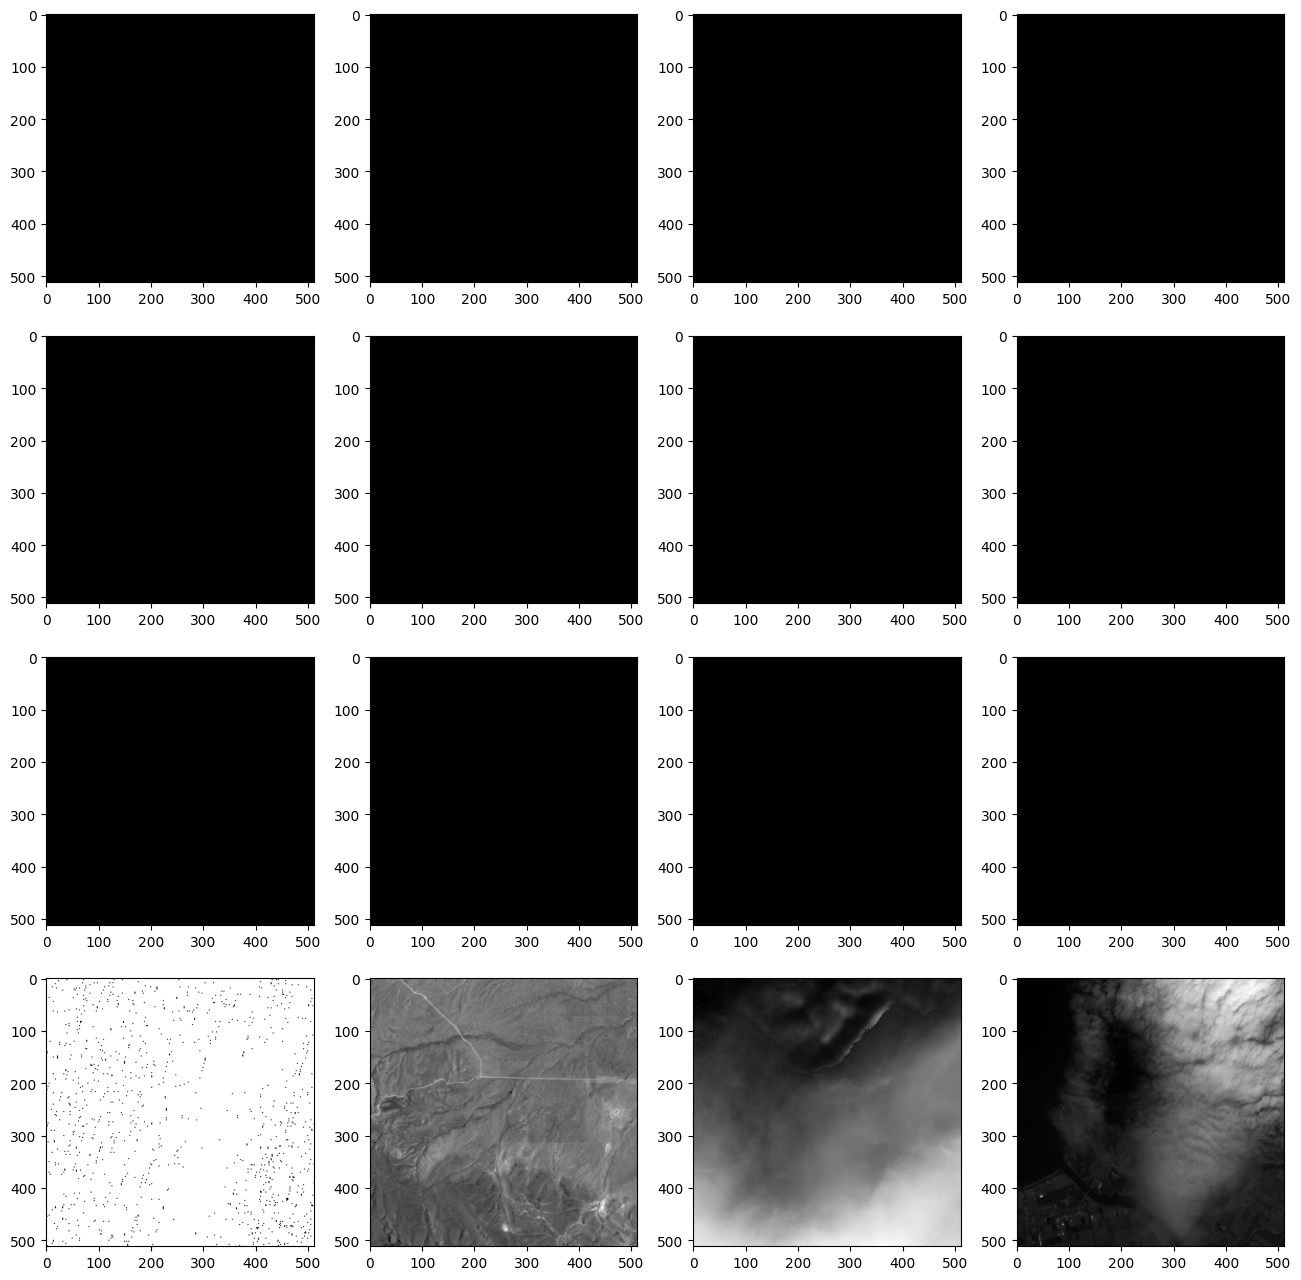

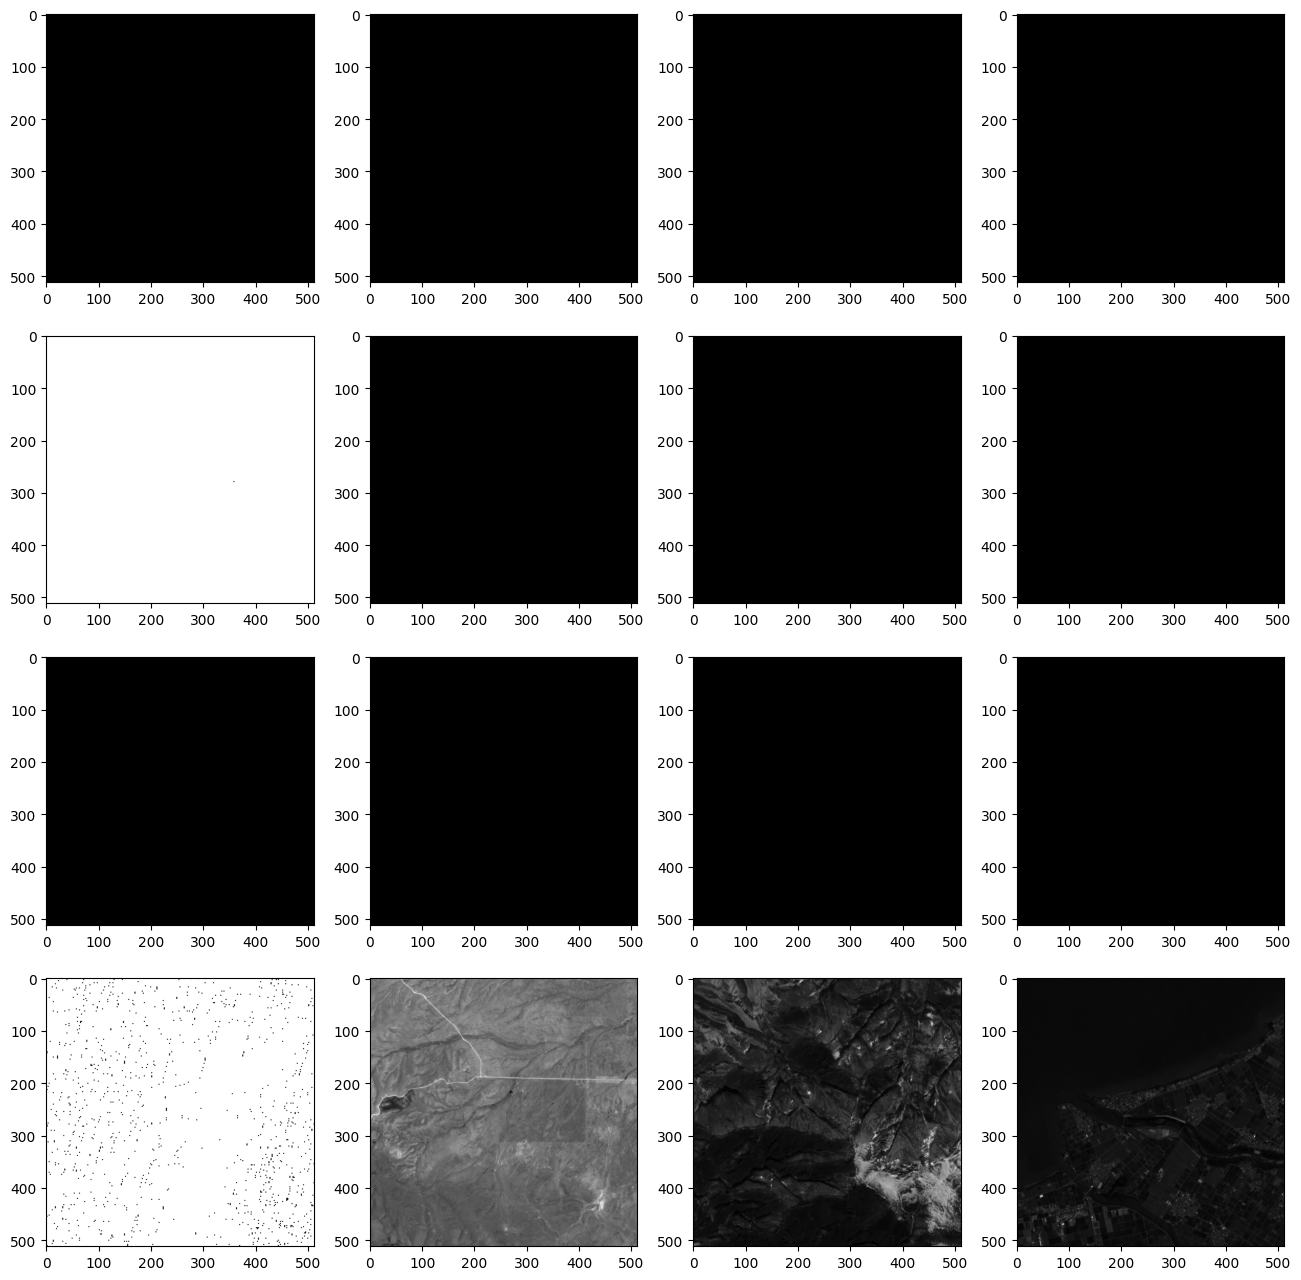

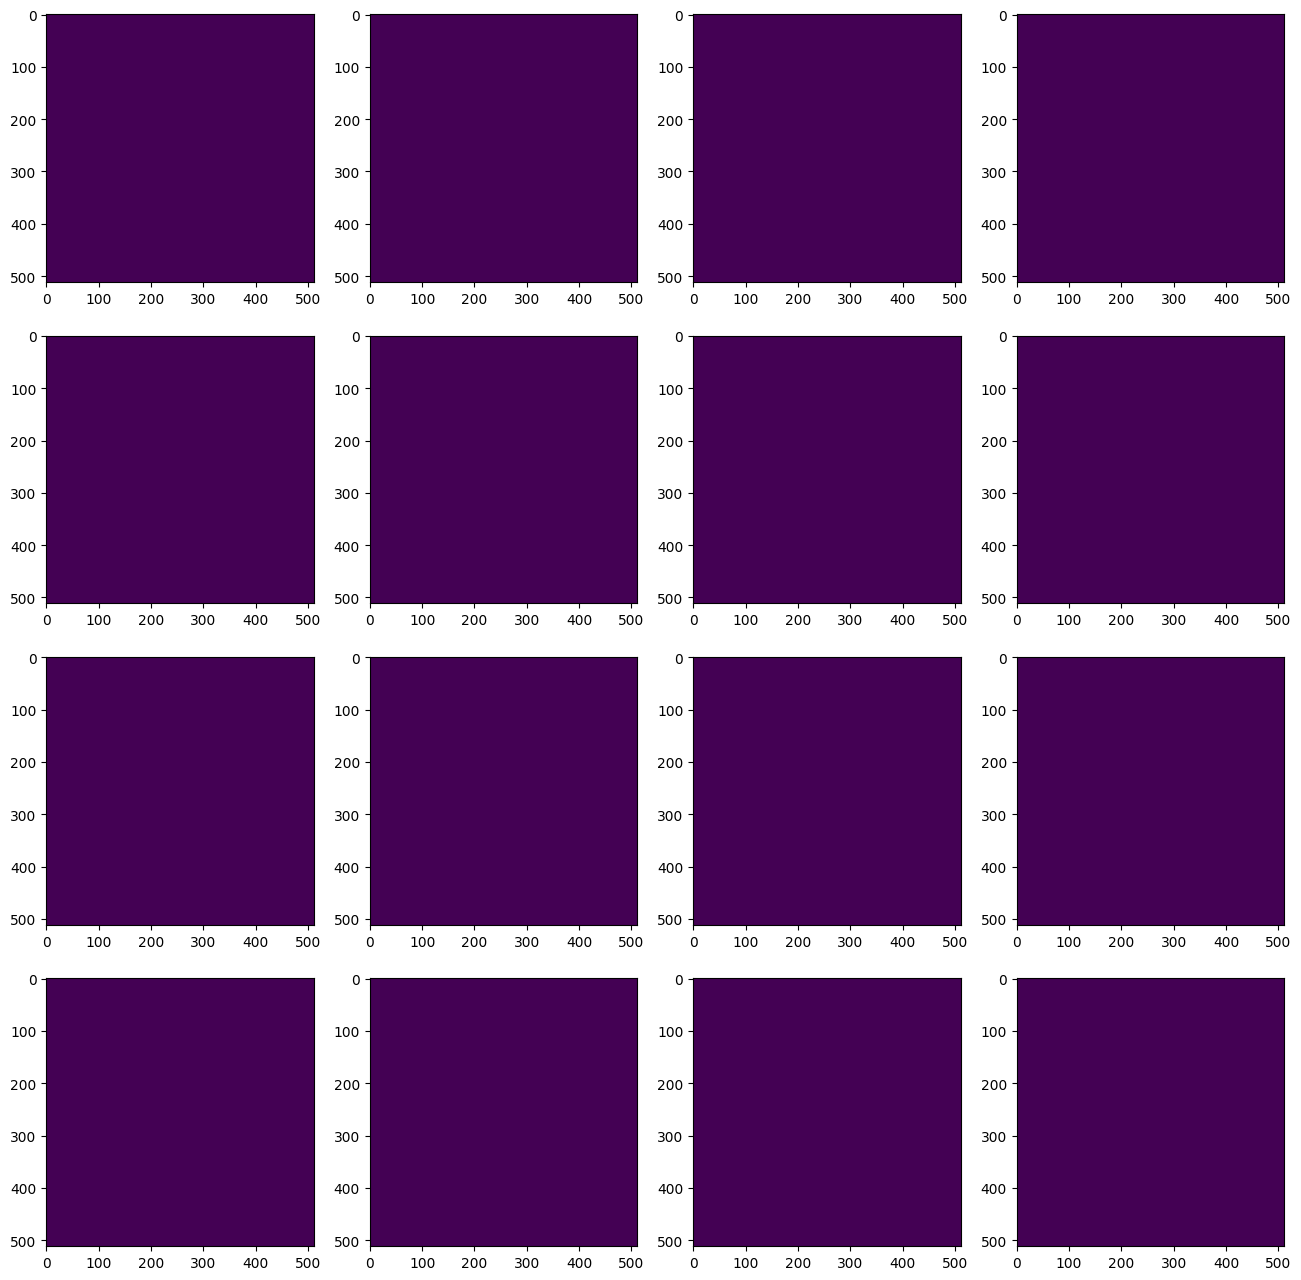

In [15]:
class FireDataset(Dataset):
    def __init__(self,
                 df,
                 phase: str,
                 ):
        self.df = df
        self.phase = phase
        self.transform = tf_dict[self.phase]
        print(f"######## Phase {phase} Num sample:", len(self.df))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        if row.area in ['tokyo', 'nagoya', 'Arizona', 'Nevata', 'Oregon']:
            
            if self.phase == 'train':
                
                PATH_FEAT = row.feature
                img_idx = np.load(PATH_FEAT).astype(np.float32)
                PATH_FEAT_SAME = random.sample(row.same_idx, 1)[0]
                img_same = np.load(PATH_FEAT_SAME).astype(np.float32)
                
                img = np.concatenate([img_idx, img_same], axis=2)
            else:

                PATH_FEAT = row.feature
                img_idx = np.load(PATH_FEAT).astype(np.float32)
                img = np.concatenate([img_idx, img_idx], axis=2)
            
            mask = np.zeros((cfg.preprocess.input_size, cfg.preprocess.input_size), dtype=np.float32)
            
        else:
            PATH_FEAT = row.feature
            img = np.load(PATH_FEAT).astype(np.float32)
        
            # use defect mask
            PATH_MASK = row['mask']
            mask = np.load(PATH_MASK).astype(np.float32)
        
        # augmentation
        transformed = self.transform(image=img, mask=mask)
        
        img, mask = transformed["image"], transformed["mask"]
        return img, mask
    
class FireModule(LightningDataModule):
    def __init__(
        self,
        df_train,
        df_valid,
        cfg,
    ):
        super().__init__()
        self._cfg = cfg
        self.df_train = df_train
        self.df_valid = df_valid

    def train_dataloader(self):
        dataset = FireDataset(self.df_train, phase='train')
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = FireDataset(self.df_valid, phase='val')
        return DataLoader(dataset, **self._cfg.val_loader)


sample_dataloader = FireModule(df, df, cfg).val_dataloader()
for (imgs, masks) in tqdm(sample_dataloader):
    # is in positive
    # print(imgs.shape, masks.shape, geomasks.shape)
    print(imgs.shape, masks.shape,)
    break

num = 16

os.makedirs(os.path.join(cfg.outdir, 'artifact'), exist_ok=True)

plt.figure(figsize=(16, 16), facecolor='white')
for it, img in enumerate(imgs[:num]):
    plt.subplot(4, 4, it+1)
    plt.imshow(img[2].numpy(), cmap='gray')
    
    # plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'023_image_visualize_tiles_val.png'))
plt.show();

plt.figure(figsize=(16, 16), facecolor='white')
for it, mask in enumerate(masks[:num]):
    plt.subplot(4, 4, it+1)
    plt.imshow(mask.numpy())
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'023_mask_visualize_tiles_val.png'))
plt.show();

plt.clf()
plt.close()

sample_dataloader = FireModule(df, df, cfg).train_dataloader()
for (imgs, masks) in tqdm(sample_dataloader):
    # is in positive
    # print(imgs.shape, masks.shape, geomasks.shape)
    print(imgs.shape, masks.shape,)
    break

num = 16

os.makedirs(os.path.join(cfg.outdir, 'artifact'), exist_ok=True)

plt.figure(figsize=(16, 16), facecolor='white')
for it, img in enumerate(imgs[:num]):
    plt.subplot(4, 4, it+1)
    plt.imshow(img[2].numpy(), cmap='gray')
    
    # plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'023_image_visualize_tiles_train_post.png'))
plt.show();

plt.figure(figsize=(16, 16), facecolor='white')
for it, img in enumerate(imgs[:num]):
    plt.subplot(4, 4, it+1)
    plt.imshow(img[2+12].numpy(), cmap='gray')
    
    # plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'023_image_visualize_tiles_train_pre.png'))
plt.show();

plt.figure(figsize=(16, 16), facecolor='white')
for it, mask in enumerate(masks[:num]):
    plt.subplot(4, 4, it+1)
    plt.imshow(mask.numpy())
plt.savefig(os.path.join(cfg.outdir, 'artifact', f'023_mask_visualize_tiles_train.png'))
plt.show();

plt.clf()
plt.close()

## Model

In [16]:
from utils.models import TimmUnet
from torchmetrics.functional.classification import binary_fbeta_score

class FHalfWithLogitsLoss(torch.nn.Module):
    """ Fbeta Extended  with logits Loss """
    def __init__(self, eps=cfg.eps, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta

    def forward(self, y_pr, y_gt):
        return 1 - binary_fbeta_score(torch.sigmoid(y_pr), y_gt, beta=self.beta)

class BCEDiceLoss(torch.nn.Module):
    """ Combine Loss """
    def __init__(self, raito=0.5, beta=0.5):
        super(BCEDiceLoss, self).__init__()
        assert 0 <= raito <= 1, "loss raito invalid."
        
        self.raito = raito
        self.bce_criterion = torch.nn.BCEWithLogitsLoss()
        self.dice_criterion = FHalfWithLogitsLoss(beta=beta)
        
    def forward(self, y_pr, y_gt):
        loss = self.raito * self.bce_criterion(y_pr, y_gt) + (1 - self.raito) * self.dice_criterion(y_pr, y_gt)
        return loss
    
def mixup(x: torch.Tensor, y: torch.Tensor,alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam


class FireModel(LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self._criterion = eval(cfg.model.loss)
        
    def __build_model(self):
        self.backbone = TimmUnet(
            **self.cfg.model.timmunet.encoder_params,
            )

    def forward(self, x):
        feat = self.backbone(x)
        return feat.squeeze(1)

    def training_step(self, batch, batch_idx):
        return self.__share_step(batch, 'train')
        
    def validation_step(self, batch, batch_idx):
        return self.__share_step(batch, 'val')
    
    def __share_step(self, batch, mode):
        images, labels = batch
        labels = labels.float()
        images = images.float()

        if torch.rand(1)[0] < self.cfg.MIXUP_RATIO and mode == 'train':
            mix_images, target_a, target_b, lam = mixup(images, labels,alpha=0.5)
            feat = self.forward(mix_images)
            loss = self._criterion(feat, target_a) * lam + (1 - lam) * self._criterion(feat, target_b)
        
        else:
            feat = self.forward(images)
            # loss
            loss = self._criterion(feat, labels)
        
        logits = torch.sigmoid(feat)
        preds = (logits > cfg.model.threshold).float()
        return_dict = {'loss': loss }
        
        # metrics
        tp = (preds * labels).sum().to(torch.float32)
        tn = ((1. - preds) * (1. - labels)).sum().to(torch.float32)
        fp = (preds * (1. - labels)).sum().to(torch.float32)
        fn = ((1. - preds) * labels).sum().to(torch.float32)
        return_dict[f'TP'] = tp.unsqueeze(dim=0).detach().cpu()
        return_dict[f'TN'] = tn.unsqueeze(dim=0).detach().cpu()
        return_dict[f'FP'] = fp.unsqueeze(dim=0).detach().cpu()
        return_dict[f'FN'] = fn.unsqueeze(dim=0).detach().cpu()
        
        precision = tp / (tp + fp + 1)
        recall = tp / (tp + fn + 1)
        f1 = 2 * (precision*recall) / (precision + recall + cfg.eps)
        iou = tp / (tp + fp + fn + 1)
        
        return_dict[f'Precision'] = precision.unsqueeze(dim=0).detach().cpu()
        return_dict[f'Recall'] = recall.unsqueeze(dim=0).detach().cpu()
        return_dict[f'F1'] = f1.unsqueeze(dim=0).detach().cpu()
        return_dict[f'IoU'] = iou.unsqueeze(dim=0).detach().cpu()
        
        # logging 
        self.log(f'{mode}/iter_TP', tp)
        self.log(f'{mode}/iter_TN', tn)
        self.log(f'{mode}/iter_FP', fp)
        self.log(f'{mode}/iter_FN', fn)
        
        self.log(f'{mode}/iter_Precision', precision)
        self.log(f'{mode}/iter_Recall', recall)
        
        self.log(f'{mode}/iter_F1', f1)
        self.log(f'{mode}/iter_IoU', iou) 
            
        self.log(f'{mode}/iter_loss', loss.detach().cpu())         

        return return_dict
        
    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        
        # loss
        losses = []
        for out in outputs:
            losses.append(out['loss'].cpu().detach().numpy())
        losses = np.mean(losses)
        self.log(f'{mode}/epoch_loss', losses)
    
        # metrics
        tps, tns, fps, fns, precisions, recalls, f1s, IoUs = \
            [], [], [], [], [], [], [], []
        for out in outputs:
            # assert False, (out[f'TP'], out[f'TP'].shape)
            for (tp, tn, fp, fn, precision, recall, f1, iou) in zip(out[f'TP'], 
                                        out[f'TN'],
                                        out[f'FP'],
                                        out[f'FN'],
                                        out[f'Precision'],
                                        out[f'Recall'],
                                        out[f'F1'],
                                        out[f'IoU'],):
                
                tps.append(tp.unsqueeze(dim=0))
                tns.append(tn.unsqueeze(dim=0))
                fps.append(fp.unsqueeze(dim=0))
                fns.append(fn.unsqueeze(dim=0))
                
                precisions.append(precision.unsqueeze(dim=0))
                recalls.append(recall.unsqueeze(dim=0))
                f1s.append(f1.unsqueeze(dim=0))
                IoUs.append(iou.unsqueeze(dim=0))
                
        tps = torch.cat(tps, dim=0).squeeze()
        tns = torch.cat(tns, dim=0).squeeze()
        fps = torch.cat(fps, dim=0).squeeze()
        fns = torch.cat(fns, dim=0).squeeze()
        
        precisions = torch.cat(precisions, dim=0).squeeze()
        recalls = torch.cat(recalls, dim=0).squeeze()
        f1s = torch.cat(f1s, dim=0).squeeze()
        IoUs = torch.cat(IoUs, dim=0).squeeze()
        
        
        # logging 
        self.log(f'{mode}/epoch_TP', tps)
        self.log(f'{mode}/epoch_TN', tns)
        self.log(f'{mode}/epoch_FP', fps)
        self.log(f'{mode}/epoch_FN', fns)
        
        self.log(f'{mode}/epoch_Precision', precisions)
        self.log(f'{mode}/epoch_Recall', recalls)
        
        self.log(f'{mode}/epoch_F1', f1s)
        self.log(f'{mode}/epoch_IoU', IoUs)

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## Train

In [17]:
for fold in range(cfg.folds):
    print('◇'*30, f" fold: {fold}", '◇'*30)

    # train val split 
    train_df = df[df['cv'] != fold]
    val_df = df[df['cv'] == fold]
    
    # missing data
    if cfg.REMOVE_POST_MISSING:
        train_df = train_df[train_df['post_missing'] == False]
    if cfg.REMOVE_PRE_MISSING:
        train_df = train_df[train_df['pre_missing'] == False]
    
    # validation data is purely official fold data
    val_df = val_df[(val_df['defects'] == False) & (val_df['fold'] != -1)].reset_index(drop=True) # always save validation score tracing

        
    if cfg.debug:
        print(f'DEBUG MODE -> sample pulse:{cfg.debug_sample}')
        train_df = train_df[:cfg.debug_sample]
        val_df   = val_df[:cfg.debug_sample]

    print(f'[Num Sample] Train: {len(train_df)} Valid:{len(val_df)}');
    assert len(train_df) > 0 and len(val_df) > 0, f'[num sample] train: {len(train_df)} val:{len(val_df)}'

    datamodule = FireModule(train_df, val_df, cfg)
    model = FireModel(cfg)

    # metrics
    logging_dir = f"{cfg.outdir}{cfg.group}/{cfg.runname}_fold{fold}"
    loss_checkpoint = callbacks.ModelCheckpoint(
        dirpath=logging_dir ,
        filename=f"iou_fold{fold}",
        monitor="val/epoch_IoU",
        save_top_k=1,
        mode="max",
        save_last=True,
    )

    # logger
    tb_logger = TensorBoardLogger(logging_dir)
    wandb_logger = WandbLogger(
        name=cfg.runname,
        group=cfg.group,
        project=cfg.project,
        config=cfg,
        tags=[f'fold{fold}', cfg.ENV, f'V{cfg.VERSION}'],
        entity='spaceshift',
    )
    csv_logger = CSVLogger(
        save_dir=logging_dir,
        name=f'train_fold{fold}', 
        prefix=f'V{cfg.VERSION}', 
        flush_logs_every_n_steps=10)
    lr_monitor = callbacks.LearningRateMonitor()
    # earystopping = EarlyStopping(
    #     patience=cfg.early_stop_patience,
    #     monitor="val/epoch_IoU"
    #     )

    # train
    trainer = pl.Trainer(
        logger=[tb_logger, wandb_logger, csv_logger],
        max_epochs=cfg.epoch,
        # callbacks=[lr_monitor, loss_checkpoint, earystopping],
        callbacks=[lr_monitor, loss_checkpoint],
        **cfg.trainer,
    )
    trainer.fit(model, datamodule=datamodule)

    # infomation save
    df.to_csv(f'{logging_dir}/fold.csv', index=False)
    cfg.to_json(f'{logging_dir}/cfg.json', indent=4)
    wandb.save(cfg.notebook)
    wandb.finish()
    
    if cfg.SINGLE_FOLD:
        break

◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇  fold: 0 ◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇◇
[Num Sample] Train: 25396 Valid:76


wandb: Currently logged in as: syuchimu (spaceshift). Use `wandb login --relogin` to force relogin


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params
-------------------------------------------
0 | backbone   | TimmUnet    | 28.5 M
1 | _criterion | BCEDiceLoss | 0     
-------------------------------------------
28.5 M    Trainable params
0         Non-trainable params
28.5 M    Total params
114.131   Total estimated model params size (MB)
Missing logger folder: output/V12/3090_V12_CALFalseDEFTrueNONTrue_hrnet_w30BC16TH0.3_R-RPM_R-RPM_fl-tr-gr_WD0.0001E10GA2BETA0.25MIX0.5B16/3090_fold0/lightning_logs


######## Phase train Num sample: 25396
######## Phase val Num sample: 76


Training: 0it [00:00, ?it/s]

## Inference with Optimizing Threshold

In [ ]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fold = 0

PATH_MODEL_ROOT = f"{cfg.outdir}{cfg.group}/{cfg.runname}_fold{fold}"
PATH_MODEL = f'{PATH_MODEL_ROOT}/iou_fold{fold}.ckpt'
PATH_CFG   = f'{PATH_MODEL_ROOT}/cfg.json'

print(PATH_MODEL, PATH_CFG, '\n')


# restore
inf_cfg = from_file.box_from_file(PATH_CFG)
model = FireModel.load_from_checkpoint(PATH_MODEL, cfg=inf_cfg)
model.eval()
model = model.to(device)

print(f'EVALUATE FOLD: {fold} DEVICE: {device}\n WEIGHT: {PATH_MODEL_ROOT}')

# output
save_preds_dir = f'{PATH_MODEL_ROOT}/inference/visualize/'
os.makedirs(save_preds_dir, exist_ok=True)

In [ ]:
dfs = list()

for fold in range(cfg.folds):
    
    # fold setting
    PATH_MODEL_ROOT = f"{cfg.outdir}{cfg.group}/{cfg.runname}_fold{fold}"
    PATH_MODEL = f'{PATH_MODEL_ROOT}/iou_fold{fold}.ckpt'
    PATH_CFG   = f'{PATH_MODEL_ROOT}/cfg.json'
    print(PATH_MODEL, PATH_CFG, '\n')
    

    # output
    save_preds_dir = f'{PATH_MODEL_ROOT}/inference/visualize/'
    os.makedirs(save_preds_dir, exist_ok=True)
    
    # model
    cfg = from_file.box_from_file(PATH_CFG)
    model = FireModel.load_from_checkpoint(PATH_MODEL, cfg=cfg)
    model.eval()
    if cfg.debug:
        device = torch.device('cpu')

    model = model.to(device)
    print(f'{device=}')
    
    val_df = df[df['cv'] == fold].reset_index(drop=True)
    ds_val = FireDataset(val_df, phase='val')
    cfg.val_loader.batch_size = 1
    dl_val = DataLoader(ds_val, **cfg.val_loader)
    
    running_tp = []
    running_fp = []
    running_fn = []
    running_union = []
    running_iou = []
    filenames = []
    precisions = []
    recalls = []
    f1s = []
    ious = []
    positives = []
    thresholds = []
    positive_ratios = []
    count = 0
    
    print(f'#'*60)
    print(f'### Fold: {fold}')
    print(f'#'*60)
    print(f'### Start Inference')


    for i, (images, labels) in enumerate(dl_val):
        current_image_filename = val_df.iloc[i]['name']
        print("###### Evaluating: ", f'{i+1}/{len(ds_val)}', os.path.basename(current_image_filename))
        
        # cuda
        images = images.to(device)
        images = images.float()

        # inference
        with torch.no_grad():
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs) # B, H, W
        
        outputs = outputs.cpu().numpy()
        images = images.cpu().numpy()
        
        # Allocate False Color
        preimg, postimg = images[0, 3+12:6+12, :, :], images[0, 3:6, :, :] # B, C:24, H, W
        fire = labels[0].cpu().numpy() # B, H, W
        outputs = outputs[0, :, :] # H, W
        
        # min max normalization for png images
        preimg_ = (preimg - preimg.min()) / (preimg.max() - preimg.min())
        postimg_ = (postimg - postimg.min()) / (postimg.max() - postimg.min())
        fire_ = (fire - fire.min()) / (fire.max() - fire.min())
        output_ = (outputs - outputs.min()) / (outputs.max() - outputs.min())
            
        # save image
        preimg_ = (preimg_ * 255).astype(np.uint8).transpose(1, 2, 0)
        postimg_ = (postimg_ * 255).astype(np.uint8).transpose(1, 2, 0)
        fire_ = (fire_ * 255).astype(np.uint8)
        output_ = (output_ * 255).astype(np.uint8)
        
        # save image
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_pre.png', preimg_)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_post.png', postimg_)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_fire.png', fire_)
        cv2.imwrite(f'{save_preds_dir}/{os.path.basename(current_image_filename)}_output.png', output_)
        del preimg_, postimg_, fire_, output_
            
        # metrics
        gt = fire.copy()
        prediction = outputs.copy()

        tp = np.rint(prediction * gt)
        fp = np.rint(prediction - tp)
        fn = np.rint(gt - tp)
        union = np.rint(np.sum(prediction + gt - tp))

        iou = np.sum(tp) / (np.sum(prediction + gt - tp) + 1)
        tp = np.sum(tp).astype(int)
        fp = np.sum(fp).astype(int)
        fn = np.sum(fn).astype(int)
        
        precision = tp / (tp + fp + 1)
        recall = tp / (tp + fn + 1)
        f1 = 2 * precision * recall / (precision + recall + cfg.eps)
        
        running_tp.append(tp)
        running_fp.append(fp)
        running_fn.append(fn)
        running_union.append(union)
        running_iou.append(iou)
        
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        ious.append(iou)
        
        if np.max(fire) < 0.5:
            positives.append(False)
        else:
            positives.append(True)
            
        num_pos = np.sum(fire)
        num_neg = np.sum(1 - fire)
        positive_ratios.append(num_pos / (num_pos + num_neg))
        
        count += 1
        

        # optimize threshold
        def _opt(x):
            return -jaccard_score(fire, outputs >= x, average='micro') 
        
        result = minimize(_opt, x0=np.array([0.45]), method='Powell', tol=1e-2)
        best_th = result['x'].item()
        thresholds.append(best_th)   
        
    running_tp = np.array(running_tp)
    running_fp = np.array(running_fp)
    running_fn = np.array(running_fn)
    running_union = np.array(running_union)
    running_iou = np.array(running_iou)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    ious = np.array(ious)
    
    
    
    # foldout metrics
    print()
    val_df[f'tp'] = running_tp
    val_df[f'fp'] = running_fp
    val_df[f'fn'] = running_fn
    precision = running_tp / (running_tp + running_fp + 1)
    recall = running_tp / (running_tp + running_fn + 1)
    f1 = 2 * (precision * recall) / (precision + recall + cfg.eps)
    iou = np.clip(running_tp / (running_union + cfg.eps), a_max=1.,a_min=0.0)
    print("  precision: ", precision.mean())
    val_df[f'precision'] = precision
    print("  recall: ", recall.mean())
    val_df[f'recall'] = recall
    print("  f1: ", f1.mean())
    val_df[f'f1'] = f1
    print("  iou: ", iou.mean())
    val_df[f'iou'] = iou
    
    val_df[f'threshold'] = thresholds
    print(" threshold: ", np.mean(thresholds))
    val_df[f'positive'] = positives
    val_df[f'positive_ratio'] = positive_ratios

    val_df.to_csv(f'{PATH_MODEL_ROOT}/inference/oof_fold{fold}_threshold{cfg.model.threshold}.csv', index=False, header=True)
    dfs.append(val_df)
    
    if cfg.SINGLE_FOLD:
        break
    
val_df = pd.concat(dfs)

## Analysis

In [ ]:
col = 'threshold'
plt.scatter(x=val_df.index, y=val_df[col], c='DarkBlue')
mean_th = val_df[col].values.mean()
print(f'threshold mean: {mean_th}')

plt.axhline(y=mean_th, xmin=0, xmax=len(val_df))
plt.savefig(f'{PATH_MODEL_ROOT}/inference/threshold_all_fold{fold}.png')
# plt.show();
plt.clf()
plt.close()

val_df[col] = np.clip(val_df[col].values, a_min=0, a_max=1)

# normal values
val_pos_df = val_df[val_df['positive'] == True]
bet_th = val_pos_df[(val_pos_df[col] < 1.0) & (val_pos_df[col] > 0.)]
mean_th = bet_th[col].values.mean()
print(f'thresh hold mean: {mean_th}')

plt.scatter(x=val_pos_df.index, y=np.clip(val_pos_df[col].values, a_min=0, a_max=1), c='DarkBlue')
plt.axhline(y=mean_th, xmin=0, xmax=len(bet_th), color='r')
plt.savefig(f'{PATH_MODEL_ROOT}/inference/threshold_better_fold{fold}.png')
plt.show();

sns.displot(data=val_pos_df, x="threshold", col="positive", hue='california', kde=True, bins=20)

for col in ['precision', 'recall', 'f1', 'iou', 'positive_ratio']:
    for col_v in ['precision', 'recall', 'f1', 'iou']:
        if col == col_v:
            continue
        sns.displot(data=val_pos_df, x=col, y=col_v, kind='kde', rug=True)
        
        plt.savefig(f'{PATH_MODEL_ROOT}/inference/dist{col}-{col_v}_fold{fold}_2d.png')
        # plt.show();
        plt.clf()
        plt.close()
    sns.displot(data=val_pos_df, x=col, kde=True, bins=20, color='tomato')
    plt.savefig(f'{PATH_MODEL_ROOT}/inference/dist_{col}_fold{fold}.png')
    plt.show();
    plt.clf()
    plt.close()

val_pos_df = val_df[val_df['positive'] == True]

# Only positive data
iou_positive_zero_score = val_pos_df['iou'].values.mean()
print('IoU Psitive Only', iou_positive_zero_score)

# Negative data values -> 0
iou_positive_zero_score = val_df['iou'].values.mean()
print('IoU include Negative and Zero', iou_positive_zero_score)

# Negative data values -> 1
val_df.loc[val_df['iou'] == 0.0, 'iou'] = 1
val_df['iou'].values.mean()
iou_positive_one_score = val_df['iou'].values.mean()
print('IoU include Negative and One', iou_positive_one_score)

sns.displot(data=val_pos_df, x='iou', kde=True, bins=40, color='turquoise')
plt.savefig(f'{PATH_MODEL_ROOT}/inference/dist_{col}.png')
plt.show();
plt.clf()
plt.close()

In [ ]:
TOP_N = 16
df_error = val_pos_df.sort_values(by=['iou','name'], ascending=[True, True,],)
df_error_top = df_error[:TOP_N]
df_error_top[['iou', 'name']]

In [ ]:
os.makedirs(os.path.join(cfg.outdir, 'inference_analysis'), exist_ok=True)

cfg.val_loader.batch_size = TOP_N
sample_dataloader = FireModule(df_error_top, df_error_top, cfg).val_dataloader()
for (imgs, masks) in tqdm(sample_dataloader):
    # is in positive
    print(imgs.shape, masks.shape)

plt.figure(figsize=(24, 24), facecolor='white')
for it, img in enumerate(imgs):
    plt.subplot(4, 4, it+1)
    uuid = df_error_top.iloc[it]['name']
    plt.title(uuid)
    plt.imshow(img[3].numpy(), alpha=0.5)
    plt.imshow(img[2].numpy(), alpha=0.5)
    plt.imshow(img[1].numpy(), alpha=0.5)
    
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 'inference_analysis', f'023_post_image_visualize_tiles_error.png'))
# plt.show();
plt.clf()
plt.close()

plt.figure(figsize=(24, 24), facecolor='white')
for it, img in enumerate(imgs):
    plt.subplot(4, 4, it+1)
    uuid = df_error_top.iloc[it]['name']
    plt.title(uuid)
    plt.imshow(img[3 + 12].numpy(), alpha=0.5)
    plt.imshow(img[2 + 12].numpy(), alpha=0.5)
    plt.imshow(img[1 + 12].numpy(), alpha=0.5)
    
    plt.axis('off')
plt.savefig(os.path.join(cfg.outdir, 'inference_analysis', f'023_pre_image_visualize_tiles_error.png'))
# plt.show();
plt.clf()
plt.close()

plt.figure(figsize=(24, 24), facecolor='white')
for it, mask in enumerate(masks):
    plt.subplot(4, 4, it+1)
    uuid = df_error_top.iloc[it]['name']
    plt.title(uuid)
    plt.imshow(mask.numpy())
plt.savefig(os.path.join(cfg.outdir, 'inference_analysis', f'023_mask_visualize_tiles_error.png'))
# plt.show();
plt.clf()
plt.close()

plt.figure(figsize=(24, 24), facecolor='white')
for it, mask in enumerate(masks):
    row = df_error_top.iloc[it]
    fold = row['cv']
    uuid = df_error_top.iloc[it]['name']
    
    PATH_MODEL_ROOT = f"{cfg.outdir}{cfg.group}/{cfg.runname}_fold{fold}"
    pred = cv2.imread(f'{PATH_MODEL_ROOT}/inference/visualize/{uuid}_output.png', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
    
    plt.subplot(4, 4, it+1)
    plt.title(f'{uuid} - fold{fold}')
    plt.imshow(mask.numpy(), alpha=0.5)
    plt.imshow(pred, alpha=0.5, cmap='jet')
plt.savefig(os.path.join(cfg.outdir, 'inference_analysis', f'023_mask-predict_visualize_tiles_error.png'))
plt.show();
plt.clf()
plt.close()

for idx_band in range(12):
    plt.figure(figsize=(24, 24), facecolor='white')
    for it, (img, mask) in enumerate(zip(imgs, masks)):
        row = df_error_top.iloc[it]
        fold = row['cv']
        uuid = df_error_top.iloc[it]['name']
        
        PATH_MODEL_ROOT = f"{cfg.outdir}{cfg.group}/{cfg.runname}_fold{fold}"
        pred = cv2.imread(f'{PATH_MODEL_ROOT}/inference/visualize/{uuid}_output.png', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
        
        plt.subplot(4, 4, it+1)
        plt.title(f'B{idx_band+1} {uuid}')
        plt.imshow(np.abs(img[idx_band].numpy() - img[idx_band+12].numpy()), cmap='gray', alpha=0.9)
        plt.imshow(pred, alpha=0.4, cmap='jet', vmax=0.8)
        plt.imshow(mask.numpy(), alpha=0.4, cmap='winter')
    plt.savefig(os.path.join(cfg.outdir, 'inference_analysis', f'023_diff_mask_band{idx_band+1}_visualize_tiles_error.png'))
    if idx_band == 0:
        plt.show();
    plt.clf()
    plt.close()
    
    plt.figure(figsize=(24, 24), facecolor='white')
    for it, (img, mask) in enumerate(zip(imgs, masks)):
        plt.subplot(4, 4, it+1)
        row = df_error_top.iloc[it]
        fold = row['cv']
        uuid = df_error_top.iloc[it]['name']
        
        PATH_MODEL_ROOT = f"{cfg.outdir}{cfg.group}/{cfg.runname}_fold{fold}"
        pred = cv2.imread(f'{PATH_MODEL_ROOT}/inference/visualize/{uuid}_output.png', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
        plt.title(f'B{idx_band+1} {uuid}')
        plt.imshow(img[idx_band].numpy(), cmap='gray', alpha=0.9)
        plt.imshow(pred, alpha=0.4, cmap='jet', vmax=0.8)
        plt.imshow(mask.numpy(), alpha=0.4, cmap='winter')
    plt.savefig(os.path.join(cfg.outdir, 'inference_analysis', f'023_overlay_band{idx_band+1}_visualize_tiles_error.png'))
    
    if idx_band == 0:
        plt.show();
    plt.clf()
    plt.close()